# ResNet

In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image

# Load Data

In [2]:
name = 'dataWin.csv' if os.name == 'nt' else 'data.csv'

labels = pd.read_csv(name)
labels.head()

,path,value
0,D:\Studia\MGU\Data\PS-Battles-master\originals...,0
1,D:\Studia\MGU\Data\PS-Battles-master\photoshop...,1
2,D:\Studia\MGU\Data\PS-Battles-master\photoshop...,1
3,D:\Studia\MGU\Data\PS-Battles-master\photoshop...,1
4,D:\Studia\MGU\Data\PS-Battles-master\photoshop...,1


# Show some Data

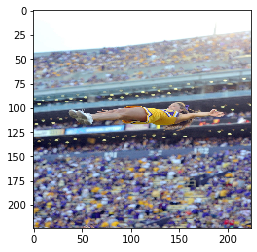

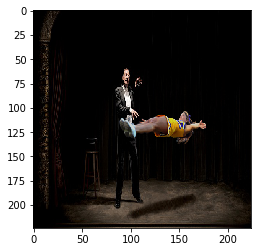

In [72]:
def get_image(path):
    img = Image.open(path)
    img = img.resize((224,224))
    img = img.convert('RGB')
#     img = np.array(img)
    return img

org_row = labels[labels.value == 0].path[0]
plt.imshow(get_image(org_row))
plt.show()

ps_row = labels[labels.value == 1].path[1]
plt.imshow(get_image(ps_row))
plt.show()

# Load data to variables and split into train and test

In [73]:
from sklearn.model_selection import train_test_split
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from keras.preprocessing.image import load_img, img_to_array, array_to_img

X = pd.DataFrame(labels.path[::1000])
y = pd.Series(labels.value[::1000].values)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.3, random_state=1234123)

In [74]:
# Dystrybucja labelek w secie treningowym
print(f'{pd.Series(y_train).value_counts()}')
print(f'{pd.Series(y_test).value_counts()}')

1    66
0     4
dtype: int64
1    28
0     2
dtype: int64


# Transfer learning

In [75]:
from keras.models import Model
import keras
from keras.applications.resnet import ResNet50

IMG_WIDTH=224
IMG_HEIGHT=224

restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))

output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)

restnet = Model(restnet.input, output=output)

# Zamrożenie wag
for layer in restnet.layers:
    layer.trainable = False
    
restnet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

d:\programs\python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  del sys.path[0]


In [76]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(restnet)

model.add(Dense(512, activation='relu', input_dim=(224, 224)))
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(32, activation='relu'))

# 1 dlatego że mamy tylko jedną etykietę
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 100352)            23587712  
_________________________________________________________________
dense_7 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)              

In [79]:
def get_images(label_dataframe):
    features_list = []
    for img in label_dataframe.path:
        img = get_image(img)
        img = load_img(img)
        features_list.append(img)
    return features_list

history = model.fit(get_images(X_train), y_train, batch_size = 16, epochs=10, validation_data=(get_images(X_test), y_test), verbose=1)

AttributeError: 'Image' object has no attribute 'read'

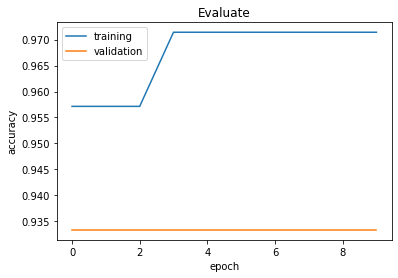

Test loss: 0.76
Test accuracy: 0.933


In [29]:
loss, accuracy  = model.evaluate(get_images(X_test), y_test, verbose=False)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Evaluate')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')


In [15]:
model.save('test_resnet50.h5')

In [60]:
if os.name == 'nt':
    path = 'D:\Studia\MGU\Data\PS-Battles-master'
    slash = '\\'
else:
    path = '../../MGU/Projekt/PS-Battles-master'
    slash = '/'

org = path + slash + 'originals' + slash + 'yipf7.jpg'
ps = path + slash + 'photoshops' + slash + 'yipf7' + slash + 'c5vytne_0.jpg'

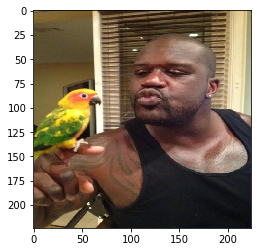

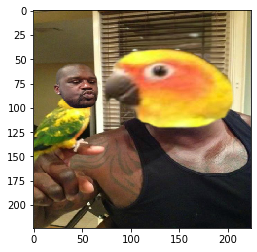

In [61]:
plt.imshow(get_image(org), cmap='gray')
plt.show()

plt.imshow(get_image(ps), cmap='gray')
plt.show()

In [62]:
org = get_image(org)
print(org.shape)
org = np.expand_dims(org, 0)
print(org.shape)
model.predict(org, verbose=1)

(224, 224, 3)
(1, 224, 224, 3)
1/1 [==============================] - 0s 144ms/step


array([[0.99945265]], dtype=float32)

In [64]:
ps = get_image(ps)
ps = np.expand_dims(ps, 0)
model.predict(ps, verbose=1)

1/1 [==============================] - 0s 132ms/step


array([[0.99954885]], dtype=float32)

# Suabo :c

# Wait what?

In [69]:
how_many = 1000

data = labels[labels.value == 0].path[:how_many]

rt = 0
for i in data:
    out = get_image(i)
    out = np.expand_dims(out, 0)
    out = model.predict(out, verbose=0)
    if out <= .5:
        print(f'{out}: {i}')
        rt += 1

print(f'{rt}')
print(f'{rt / how_many * 100:.2f} %')

KeyboardInterrupt: 

# A jakby tak po prsotu to wszystko wrzucić?

In [7]:
# from keras.models import Model
# import keras
# from keras.applications.resnet import ResNet50

# IMG_WIDTH=224
# IMG_HEIGHT=224

# restnet = ResNet50(include_top=True, weights=None, input_shape=(IMG_HEIGHT,IMG_WIDTH,3), classes=1)
# restnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [8]:
# from keras import optimizers

# restnet.compile(loss='binary_crossentropy',
#               optimizer=optimizers.Adam(lr=2e-5),
#               metrics=['accuracy'])

In [9]:
# history = restnet.fit(X_train, y_train, epochs=10, validation_split=.3, verbose=1)

Train on 161 samples, validate on 70 samples
Epoch 1/10
161/161 [==============================] - 115s 713ms/step - loss: 1.4286 - accuracy: 0.9068 - val_loss: 1.3143 - val_accuracy: 0.9143
Epoch 2/10
161/161 [==============================] - 83s 517ms/step - loss: 1.4286 - accuracy: 0.9068 - val_loss: 1.3143 - val_accuracy: 0.9143
Epoch 3/10
161/161 [==============================] - 84s 524ms/step - loss: 1.4286 - accuracy: 0.9068 - val_loss: 1.3143 - val_accuracy: 0.9143
Epoch 4/10
161/161 [==============================] - 83s 513ms/step - loss: 1.4286 - accuracy: 0.9068 - val_loss: 1.3143 - val_accuracy: 0.9143
Epoch 5/10
161/161 [==============================] - 84s 524ms/step - loss: 1.4286 - accuracy: 0.9068 - val_loss: 1.3143 - val_accuracy: 0.9143
Epoch 6/10
161/161 [==============================] - 84s 519ms/step - loss: 1.4286 - accuracy: 0.9068 - val_loss: 1.3143 - val_accuracy: 0.9143
Epoch 7/10
161/161 [==============================] - 83s 518ms/step - loss: 1.4286 

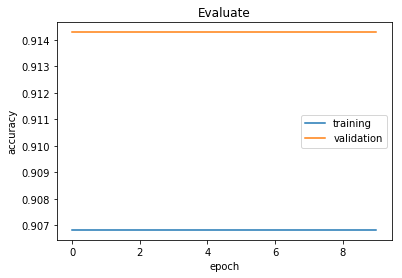

Test loss: 1.53
Test accuracy: 0.9


In [11]:
# loss, accuracy  = restnet.evaluate(X_test, y_test, verbose=False)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title(f'Evaluate')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['training', 'validation'], loc='best')
# plt.show()

# print(f'Test loss: {loss:.3}')
# print(f'Test accuracy: {accuracy:.3}')


# :c

In [19]:
# restnet.predict(org, verbose=1)

1/1 [==============================] - 0s 141ms/step


array([[1.]], dtype=float32)

In [20]:
# restnet.predict(ps, verbose=1)

1/1 [==============================] - 0s 150ms/step


array([[1.]], dtype=float32)